# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import sys
from unityagents import UnityEnvironment
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import deque

Import algorithms

In [11]:
import sys
sys.path.append('./code')
from random_action import RandomAction
from maddpg import MADDPG

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name="Tennis_Linux_NoVis/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment. Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

In [6]:
def run_algo(algo, train=False, verbose=True):

    env_info = env.reset(train_mode=train)[brain_name]
    states = env_info.vector_observations              # get the current states (for each agent)
    scores = np.zeros(num_agents)                      # initialize the score (for each agent)

    while True:
        actions = algo.act(states)                     # get next action (for each agent) 
        env_info = env.step(actions)[brain_name]       # send the action to the environment
        next_states = env_info.vector_observations     # get the next state (for each agent)
        rewards = env_info.rewards                     # get the reward (for each agent)
        dones = env_info.local_done                    # see if episode has finished
        scores += rewards                              # update the score (for each agent)
        if train:
            algo.step(states, actions, rewards, next_states, dones)
        states = next_states                           # roll over the state to next time step
        
        if np.any(dones):                              # exit loop if episode finished
            break
            
    if verbose:    
        print('Score (max over agents) for this episode: {}'.format(np.max(scores)))

    return scores

### 4. Train agents

In the next two code cells we will train agents using MADDPG algorithm. 

In [7]:
algo = MADDPG(state_size=state_size, action_size=action_size, n_agents=num_agents, seed=0)
model_file = 'checkpoint.pth'

def train_maddpg(algo, n_episodes):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
    """

    scores_all = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    algo.noise_scale = 1
    algo.epsilon = 1

    for i_episode in range(1, n_episodes+1):
        if i_episode < 1500:
            algo.epsilon = 1
        elif i_episode < 3000:
            algo.epsilon = 0.5
        else:
            algo.epsilon = 0        
        scores = run_algo(algo, train=True, verbose=False)
        scores_max = np.max(scores)
        scores_window.append(scores_max)       # save max scores from the last 100 scores
        scores_all.append(scores_max)          # save max scores from all episodes
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

        if np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, 
                                                                                         np.mean(scores_window)))
            break

    return scores_all

In [8]:
scores = train_maddpg(algo, n_episodes=100000)

Episode 16	Average Score: 0.01

/anaconda/envs/py35/lib/python3.5/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 0.01
Episode 200	Average Score: 0.01
Episode 300	Average Score: 0.02
Episode 400	Average Score: 0.01
Episode 500	Average Score: 0.02
Episode 600	Average Score: 0.02
Episode 700	Average Score: 0.02
Episode 800	Average Score: 0.02
Episode 900	Average Score: 0.03
Episode 1000	Average Score: 0.02
Episode 1100	Average Score: 0.02
Episode 1200	Average Score: 0.02
Episode 1300	Average Score: 0.01
Episode 1400	Average Score: 0.02
Episode 1500	Average Score: 0.02
Episode 1600	Average Score: 0.05
Episode 1700	Average Score: 0.04
Episode 1800	Average Score: 0.06
Episode 1900	Average Score: 0.06
Episode 2000	Average Score: 0.05
Episode 2100	Average Score: 0.06
Episode 2200	Average Score: 0.05
Episode 2300	Average Score: 0.06
Episode 2400	Average Score: 0.07
Episode 2500	Average Score: 0.06
Episode 2600	Average Score: 0.06
Episode 2700	Average Score: 0.07
Episode 2800	Average Score: 0.07
Episode 2900	Average Score: 0.06
Episode 3000	Average Score: 0.07
Episode 3100	Averag

In [15]:
algo.save_model('checkpoint.pth')

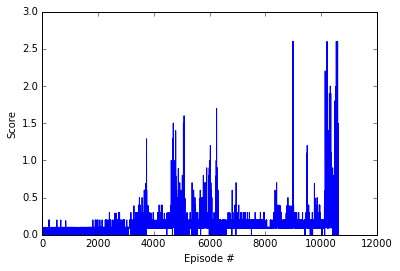

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Close environment

In [ ]:
env.close()